# 11-830 Computational Ethics for NLP
## Homework 1

In [103]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import os
from tqdm import tqdm

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

## Load the data

In [104]:
train = pd.read_table('snli/snli_1.0_train.txt', delimiter = '\t')

In [3]:
train.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


In [4]:
premises = pd.DataFrame()
premises["sentence"] = train["sentence1"]

hypotheses = pd.DataFrame()
hypotheses["sentence"] = train["sentence2"]

In [5]:
premises.head()

,sentence
0,A person on a horse jumps over a broken down a...
1,A person on a horse jumps over a broken down a...
2,A person on a horse jumps over a broken down a...
3,Children smiling and waving at camera
4,Children smiling and waving at camera


In [6]:
hypotheses.head()

,sentence
0,A person is training his horse for a competition.
1,"A person is at a diner, ordering an omelette."
2,"A person is outdoors, on a horse."
3,They are smiling at their parents
4,There are children present


In [14]:
my_file = open('identity_labels.txt', "r")
content = my_file.read()
identities = content.split('\n')
identities[:10]

['woman', 'women', 'man', 'men', 'girl', 'girls', 'boy', 'boys', 'she', 'he']

## Preprocess the data

Lowercase, remove stopwords and tokenize the data. Remove duplicates.

In [7]:
premises.drop_duplicates(inplace=True)
hypotheses.drop_duplicates(inplace=True)

In [8]:
premises.describe()

,sentence
count,150736
unique,150736
top,A person on a horse jumps over a broken down a...
freq,1


In [9]:
hypotheses.describe()

,sentence
count,480040
unique,480040
top,A person is training his horse for a competition.
freq,1


In [29]:
tokenizer = RegexpTokenizer('[a-z]\w+')

def preprocess(sentence):
    if isinstance(sentence, float):
        return []
    else:
        sentence = sentence.lower()
        tokenized = tokenizer.tokenize(sentence)
        return list(set([word for word in tokenized if word not in stop_words]))
    
preprocess('Person on a horse jumps over a broken down airplane.')

['jumps', 'broken', 'airplane', 'horse', 'person']

In [11]:
# This cell takes a while to run (~2 mins)

premises["sentence"] = premises["sentence"].map(preprocess)
hypotheses["sentence"] = hypotheses["sentence"].map(preprocess)

In [13]:
hypotheses.head(1), premises.head(1)

(                                 sentence
 0  [horse, training, competition, person],
                                    sentence
 0  [jumps, broken, airplane, horse, person])

## Get the word occurence dictionary for premise and hypothesis

In [16]:
premise_dict = {}
hyp_dict = {}

def fill_dict(source, target_dict):
    for sentence in tqdm(source.values):
        sentence = sentence[0]
        for word in sentence:
            target_dict[word] = target_dict.get(word, 0) + 1
            
fill_dict(premises, premise_dict)
fill_dict(hypotheses, hyp_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 480041/480041 [00:00<00:00, 585438.03it/s]


In [18]:
co_premise_dict = {}
co_hyp_dict = {}

def fill_co_dict(source, target_dict):
    for sentence in tqdm(source.values):
        sentence = sentence[0]
        for identity in identities:
            if identity in sentence:
                for word in sentence:
                    key = (identity, word)
                    target_dict[key] = target_dict.get(key, 0) + 1
                    
fill_co_dict(premises, co_premise_dict)
fill_co_dict(hypotheses, co_hyp_dict)

100%|█████████████████████████████████████████████████████████████████████████████████████| 480041/480041 [00:07<00:00, 67428.21it/s]


In [40]:
key = ('woman', 'man')
co_premise_dict[key]

4289

In [38]:
sorted_coprem = sorted(co_premise_dict.items(), key=lambda x: x[1], reverse=True)
[((x,y), z) for ((x,y),z) in sorted_coprem if x != y][:10]

[(('man', 'shirt'), 6610),
 (('man', 'wearing'), 4781),
 (('men', 'two'), 4756),
 (('woman', 'man'), 4289),
 (('man', 'woman'), 4289),
 (('man', 'black'), 3718),
 (('black', 'man'), 3718),
 (('man', 'white'), 3524),
 (('white', 'man'), 3524),
 (('man', 'blue'), 3508)]

In [39]:
sorted_cohyp = sorted(co_hyp_dict.items(), key=lambda x: x[1], reverse=True)
[((x,y), z) for ((x,y),z) in sorted_cohyp if x != y][:10]

[(('men', 'two'), 9304),
 (('woman', 'man'), 5924),
 (('man', 'woman'), 5924),
 (('man', 'wearing'), 4779),
 (('women', 'two'), 4681),
 (('man', 'sitting'), 3456),
 (('man', 'playing'), 3356),
 (('man', 'shirt'), 3185),
 (('man', 'young'), 2933),
 (('young', 'man'), 2933)]

In [80]:
co_premise_dict = {k:v for k,v in co_premise_dict.items() if v >= 10}
co_hyp_dict = {k:v for k,v in co_hyp_dict.items() if v >= 10}

## Calculte PMI

In [149]:
def get_pmi(wi, wj, source="premise"):
    if source == "premise":
        word_count_dic = premise_dict
        co_dict = co_premise_dict
        N = len(premises.values)
    else:
        word_count_dic = hyp_dict
        co_dict = co_hyp_dict
        N = len(hypotheses.values)
    
    c_wi = word_count_dic[wi]
    c_wj = word_count_dic[wj]
    c_wi_wj = co_dict[(wi, wj)]
    # print(c_wi, c_wj, c_wi_wj)
    
    pmi = np.log2( (N * c_wi_wj) / (c_wi * c_wj) )
    
    return pmi

In [150]:
get_pmi('woman', 'man', source="premise")

-0.2797887539473858

In [151]:
def get_pmi_all(source="premise"):
    if source == "premise":
        co_dict = co_premise_dict
    else:
        co_dict = co_hyp_dict
    
    pmi_dict = {}
    for (identity, word) in co_dict:
        key = (identity, word)
        pmi_dict[key] = get_pmi(identity, word, source)
        
    return pmi_dict

In [152]:
pmi_premise = get_pmi_all("premise")

In [153]:
pmi_hyp = get_pmi_all("hyp")

In [154]:
sorted_pmiprem = sorted(pmi_premise.items(), key=lambda x: x[1], reverse=True)
[((x,y), z) for ((x,y),z) in sorted_pmiprem if x != y][:10]

[(('senior', 'citizen'), 11.839094409326705),
 (('polish', 'nail'), 11.294773893102894),
 (('senior', 'citizens'), 10.536974795519523),
 (('german', 'shepherd'), 10.363160868083144),
 (('french', 'horn'), 9.430175019210814),
 (('father', 'son'), 7.974449683918122),
 (('son', 'father'), 7.974449683918122),
 (('straight', 'ahead'), 7.945365061793425),
 (('american', 'footballer'), 7.394309566653809),
 (('mother', 'daughter'), 7.252713288269991)]

In [155]:
sorted_pmihyp = sorted(pmi_hyp.items(), key=lambda x: x[1], reverse=True)
[((x,y), z) for ((x,y),z) in sorted_pmihyp if x != y][:10]

[(('german', 'shepherd'), 11.736773510385337),
 (('senior', 'citizen'), 11.73381530258773),
 (('german', 'shepard'), 11.68050529073859),
 (('polish', 'nail'), 11.517006558455712),
 (('buddhist', 'temple'), 11.099109405037627),
 (('senior', 'citizens'), 11.06815756784879),
 (('french', 'fries'), 11.065443183151753),
 (('gay', 'pride'), 10.717979996157254),
 (('gay', 'rights'), 9.70789117853367),
 (('french', 'horn'), 9.65040568387291)]

# Analysis

In [584]:
def get_n_highest(id_word, pmi_dict, n=10, plot=False, rotation=45, figsize=(15, 3)):
    id_list = [((x,y),z) for ((x,y),z) in pmi_dict.items() if x==id_word]
    sorted_list = sorted(id_list, key=lambda x: x[1], reverse=True)[:n]
    
    if plot:
        plt.figure(figsize=figsize)
        plt.bar([x[0][1] for x in sorted_list], [x[1] for x in sorted_list])
        plt.xticks(rotation=rotation)
        plt.show()
        
    else:
        return sorted_list


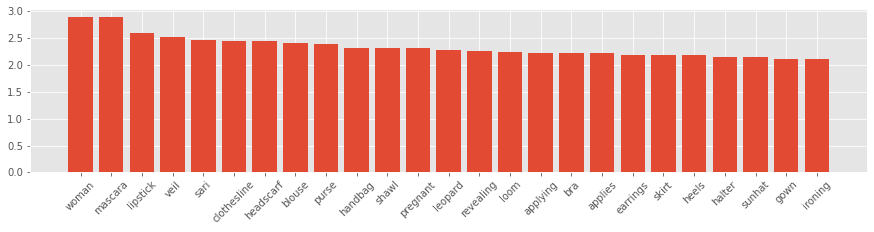

In [132]:
get_n_highest('woman', pmi_premise, n=25, plot=True)

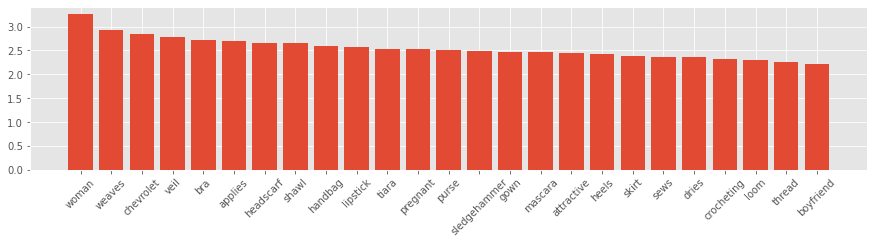

In [133]:
get_n_highest('woman', pmi_hyp, n=25, plot=True)

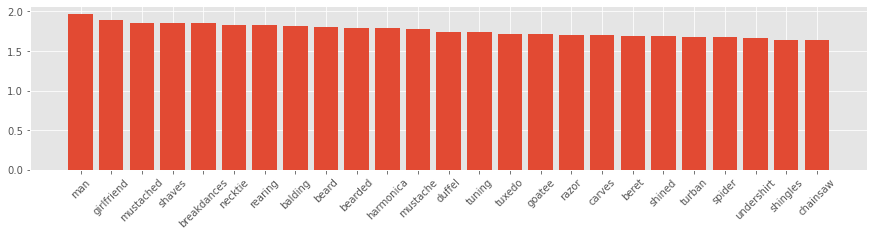

In [134]:
get_n_highest('man', pmi_premise, n=25, plot=True)

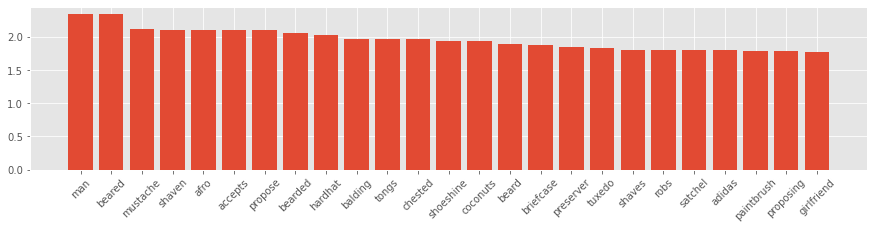

In [135]:
get_n_highest('man', pmi_hyp, n=25, plot=True)

In [218]:
pd.set_option('display.max_rows', 1000)

In [169]:
p_availabilities = {}

for identity in identities:
    p_availabilities[identity] = len(get_n_highest(identity, pmi_premise, n=10000, plot=False))

In [329]:
sorted(h_availabilities.items(), key=lambda x: x[1], reverse=True)

[('man', 3184),
 ('woman', 1993),
 ('girl', 1136),
 ('men', 1124),
 ('boy', 1041),
 ('young', 888),
 ('women', 737),
 ('black', 506),
 ('white', 462),
 ('girls', 424),
 ('old', 351),
 ('boys', 315),
 ('female', 178),
 ('asian', 170),
 ('mother', 148),
 ('male', 144),
 ('son', 96),
 ('father', 95),
 ('elderly', 76),
 ('daughter', 73),
 ('american', 39),
 ('african', 33),
 ('chinese', 23),
 ('indian', 22),
 ('sister', 21),
 ('brother', 21),
 ('teenagers', 18),
 ('teenage', 12),
 ('mexican', 11),
 ('gay', 10),
 ('straight', 9),
 ('teenager', 9),
 ('japanese', 8),
 ('french', 7),
 ('caucasian', 6),
 ('asians', 6),
 ('german', 6),
 ('hispanic', 5),
 ('italian', 5),
 ('senior', 4),
 ('polish', 3),
 ('european', 2),
 ('korean', 2),
 ('irish', 2),
 ('disabled', 2),
 ('handicapped', 2),
 ('lesbian', 2),
 ('muslim', 2),
 ('jewish', 2),
 ('buddhist', 2),
 ('latino', 1),
 ('africans', 1),
 ('australian', 1),
 ('brazilian', 1),
 ('russian', 1),
 ('thai', 1),
 ('spanish', 1),
 ('swiss', 1),
 ('israe

In [175]:
h_availabilities = {}

for identity in identities:
    h_availabilities[identity] = len(get_n_highest(identity, pmi_hyp, n=10000, plot=False))

In [281]:
def compare(w1, w2, source):
    df = pd.DataFrame()
    
    intersection = \
        [b for ((a,b), c) in get_n_highest(w1, source, n=10000, plot=False) \
         if b in [y for ((x,y),z) in get_n_highest(w2, source, n=10000, plot=False)]]

    words = []
    pmis_w1 = []
    pmis_w2 = []

    for word in intersection:
        pmi_w1 = source[(w1, word)]
        pmi_w2 = source[(w2, word)]

        words.append(word)
        pmis_w1.append(pmi_w1)
        pmis_w2.append(pmi_w2)

    df["words"] = words
    df["pmi_" + w1] = pmis_w1
    df["pmi_" + w2] = pmis_w2
    df["diff"] = df["pmi_" + w1] - df["pmi_" + w2]
    
    return df

In [381]:
def find_sentence(w1, w2, source="premise"):
    if source=="premise":
        sent = "sentence1"
    else:
        sent = "sentence2"
        
    res = set()
    count = 0
    for sentence in train[sent].values:
        if isinstance(sentence, float):
            continue
        if w1 in sentence and w2 in sentence:
            count += 1                
            res.add(sentence)
            
    return res

In [436]:
list(find_sentence("asian", "girl", "hypothesis"))[:10]

['A little asian girl out in the country.',
 'A small asian girl down a brick street runs into focus',
 'The little girl is caucasian.',
 'A photographer takes a picture of the two asian girls.',
 'Lush, well-watered foliage frames the two asian girls as they pose for a picture',
 'A white Asian boy is giving young asian girl a piggyback ride.',
 'An asian girl is sitting on something in the grass.',
 'An asian girl is sitting in a park.',
 'Two asian girls look into the distance.',
 'The two asian girls are indoors.']

### Comparison between female-male

In [644]:
female_male_prem = compare('female', 'male', source=pmi_premise)

In [647]:
female_male_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_female,pmi_male,diff
0,female,6.880864,4.045723,2.835141
11,tennis,2.672175,0.907981,1.764195
7,males,3.811702,2.234506,1.577196
135,man,-2.186122,-3.540926,1.354804
1,athlete,5.014881,3.669355,1.345526
2,gymnast,4.725586,3.396777,1.328808
10,player,2.732067,1.731720,1.000346
20,ball,1.320705,0.388414,0.932291
24,blond,1.122371,0.213465,0.908905
5,singer,4.042145,3.249936,0.792209


In [648]:
female_male_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_female,pmi_male,diff
4,male,4.045723,6.789095,-2.743372
133,water,-1.468125,-0.123795,-1.344330
123,wall,-0.749155,0.454532,-1.203687
121,hat,-0.680997,0.428868,-1.109865
128,building,-1.044405,0.021367,-1.065772
79,older,0.077583,1.130203,-1.052621
91,jeans,-0.101315,0.906452,-1.007766
100,shirt,-0.259710,0.656513,-0.916223
34,american,0.880864,1.789095,-0.908231
25,african,1.116294,1.957410,-0.841117


In [650]:
female_male_hyp = compare('female', 'male', source=pmi_hyp)

In [651]:
female_male_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_female,pmi_male,diff
0,female,7.681122,4.112066,3.569056
7,tennis,2.499224,1.136951,1.362273
111,man,-2.764897,-4.018236,1.253339
3,athlete,3.899762,2.926531,0.973231
74,walking,-0.125428,-0.876266,0.750838
65,talking,0.046311,-0.578997,0.625307
11,player,1.913653,1.400821,0.512833
8,artist,2.465832,1.978028,0.487804
101,dog,-0.935231,-1.414688,0.479457
1,gymnast,4.267494,3.812112,0.455382


In [652]:
female_male_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_female,pmi_male,diff
2,male,4.112066,8.055814,-3.943749
70,guitar,-0.045561,1.624588,-1.670148
108,play,-1.231767,0.207055,-1.438823
86,workers,-0.376131,1.062691,-1.438823
79,black,-0.207812,1.189249,-1.397060
112,woman,-3.847217,-2.472525,-1.374693
77,construction,-0.175615,1.199078,-1.374693
90,pool,-0.504166,0.744995,-1.249162
107,waiting,-1.117718,0.119471,-1.237189
80,shirt,-0.209719,0.979418,-1.189137


### Comparison between woman-man

In [295]:
woman_man = compare('woman', 'man', source=pmi_premise)

In [284]:
woman_man.sort_values("pmi_woman", ascending=False).head(5)

,words,pmi_woman,pmi_man,diff
0,woman,2.890697,-0.279789,3.170486
1,headscarf,2.440035,-0.392799,2.832834
2,blouse,2.414669,-1.205172,3.619840
3,purse,2.384806,-1.484554,3.869360
4,shawl,2.321331,-0.236880,2.558212


In [285]:
woman_man.sort_values("pmi_man", ascending=False).head(5)

,words,pmi_woman,pmi_man,diff
969,man,-0.279789,1.964753,-2.244542
1276,beard,-1.337285,1.809399,-3.146684
1159,bearded,-0.809743,1.793567,-2.603310
69,tuxedo,1.305734,1.720828,-0.415094
1218,bald,-1.037410,1.634906,-2.672316


In [286]:
woman_man[woman_man["words"] == "topless"]

,words,pmi_woman,pmi_man,diff
82,topless,1.242999,0.217519,1.025479


In [287]:
woman_man[woman_man["words"] == "dances"]

,words,pmi_woman,pmi_man,diff
110,dances,1.147855,0.335122,0.812733


In [288]:
woman_man[woman_man["words"] == "football"]

,words,pmi_woman,pmi_man,diff
1354,football,-3.073644,-1.677659,-1.395985


In [292]:
woman_man.sort_values("diff", ascending=False).head(50)

,words,pmi_woman,pmi_man,diff
3,purse,2.384806,-1.484554,3.869360
2,blouse,2.414669,-1.205172,3.619840
22,brunette,1.729874,-1.464558,3.194432
0,woman,2.890697,-0.279789,3.170486
7,heels,2.182463,-0.893228,3.075690
6,skirt,2.187168,-0.845347,3.032515
5,loom,2.235345,-0.690598,2.925943
1,headscarf,2.440035,-0.392799,2.832834
9,bikini,2.080596,-0.582313,2.662909
4,shawl,2.321331,-0.236880,2.558212


In [ ]:
# soccer, baseball, basketball, football

In [294]:
woman_man.sort_values("diff", ascending=True).head(50)

,words,pmi_woman,pmi_man,diff
1350,skateboard,-2.781729,0.684645,-3.466374
1276,beard,-1.337285,1.809399,-3.146684
1327,roof,-1.920946,0.806553,-2.727499
1218,bald,-1.037410,1.634906,-2.672316
1335,hard,-2.229397,0.429622,-2.659019
1159,bearded,-0.809743,1.793567,-2.603310
1311,surfboard,-1.653624,0.943995,-2.597619
1243,shirtless,-1.131671,1.334703,-2.466374
1312,driving,-1.686732,0.736053,-2.422785
1353,construction,-3.035303,-0.646550,-2.388753


In [296]:
woman_man_hyp = compare('woman', 'man', source=pmi_hyp)

In [297]:
woman_man_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_woman,pmi_man,diff
1885,wife,-2.624208,1.741337,-4.365545
1789,bearded,-1.309819,2.057903,-3.367722
1617,man,-0.744130,2.339316,-3.083446
1655,beard,-0.848799,1.889869,-2.738667
1873,trick,-2.292245,0.260867,-2.553112
1842,tractor,-1.756466,0.690426,-2.446893
1729,tool,-1.064932,1.265316,-2.330248
1825,repairing,-1.559697,0.763632,-2.323328
1596,shirtless,-0.714746,1.591743,-2.306488
1777,tools,-1.260852,1.034462,-2.295314


In [298]:
woman_man_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_woman,pmi_man,diff
11,husband,2.168076,-2.475048,4.643124
0,woman,3.256996,-0.744130,4.001126
1,purse,2.509439,-1.277657,3.787096
5,heels,2.428267,-1.233573,3.661841
10,bikini,2.172238,-1.285175,3.457413
6,skirt,2.377443,-0.526298,2.903741
28,nails,1.797564,-1.020580,2.818144
3,gown,2.464801,-0.350999,2.815800
15,knitting,1.948874,-0.717267,2.666141
64,yarn,1.508975,-1.109144,2.618120


### Comparison between women-men

In [309]:
women_men_prem = compare('women', 'men', source=pmi_premise)

In [312]:
women_men_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_women,pmi_men,diff
0,women,4.937222,0.527263,4.409959
1,dresses,3.716346,-0.317102,4.033448
143,blond,0.569188,-3.298638,3.867826
53,shopping,1.352259,-1.348613,2.700873
227,pink,0.127676,-2.192326,2.320002
16,dancing,2.128363,-0.150119,2.278483
207,hair,0.218027,-1.775330,1.993357
134,flowers,0.625636,-1.334155,1.959791
11,volleyball,2.262374,0.324609,1.937765
32,laughing,1.805692,-0.128104,1.933796


In [314]:
women_men_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_women,pmi_men,diff
146,men,0.527263,4.084346,-3.557083
402,boat,-1.553486,1.580699,-3.134185
420,soccer,-2.566604,0.448417,-3.015021
253,work,-0.031909,1.826354,-1.858264
334,truck,-0.550618,1.240362,-1.790980
161,instruments,0.471841,2.236349,-1.764508
245,working,0.028242,1.749836,-1.721594
133,uniforms,0.626609,2.343589,-1.716980
63,suits,1.293366,2.968869,-1.675503
252,martial,-0.021199,1.620690,-1.641889


In [316]:
women_men_hyp = compare('women', 'men', source=pmi_hyp)

In [317]:
women_men_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_women,pmi_men,diff
417,men,-0.160546,4.298382,-4.458928
577,fishing,-0.959444,1.564364,-2.523807
584,roof,-1.022226,1.426030,-2.448256
630,construction,-1.587746,0.741769,-2.329515
127,guitars,0.873585,3.068084,-2.194500
568,horses,-0.888293,1.249623,-2.137916
614,fish,-1.327106,0.724098,-2.051204
589,truck,-1.065885,0.899329,-1.965214
627,fire,-1.518490,0.311573,-1.830063
533,boat,-0.642958,1.168730,-1.811688


In [318]:
women_men_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_women,pmi_men,diff
0,women,5.067357,-0.160546,5.227902
217,flowers,0.461083,-2.240777,2.701860
2,dresses,3.198916,0.519738,2.679178
559,baby,-0.818438,-3.454146,2.635708
1,skirts,3.844964,1.353524,2.491441
41,sewing,1.677122,-0.814318,2.491441
7,umbrellas,2.402224,0.088929,2.313295
42,shopping,1.667426,-0.593402,2.260828
316,hair,0.161924,-2.026954,2.188878
100,roller,1.077698,-0.913669,1.991367


### Comparison between girl-boy

In [319]:
girl_boy_prem = compare('girl', 'boy', source=pmi_premise)

In [320]:
girl_boy_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_girl,pmi_boy,diff
0,girl,4.082075,0.434244,3.647831
13,dress,2.191089,-1.434901,3.625991
3,pink,2.633820,-0.668282,3.302101
39,skirt,1.613011,-1.227589,2.840600
245,painting,0.393004,-1.870962,2.263966
45,flowers,1.502293,-0.686123,2.188415
18,flower,2.066015,0.028741,2.037274
84,tank,1.201852,-0.817695,2.019547
57,purple,1.411896,-0.449105,1.861002
218,volleyball,0.487397,-1.371312,1.858710


In [321]:
girl_boy_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_girl,pmi_boy,diff
231,boy,0.434244,4.110890,-3.676646
557,skateboard,-1.005388,2.045795,-3.051183
606,trick,-1.906610,0.707168,-2.613778
210,bat,0.519832,2.657172,-2.137340
616,football,-2.422834,-0.427186,-1.995649
446,swim,-0.265388,1.683993,-1.949381
573,basketball,-1.192025,0.705546,-1.897571
601,dirt,-1.809433,-0.070124,-1.739309
527,baseball,-0.775906,0.945586,-1.721492
203,shovel,0.537754,1.951234,-1.413479


In [322]:
girl_boy_hyp = compare('girl', 'boy', source=pmi_hyp)

In [323]:
girl_boy_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_girl,pmi_boy,diff
521,boy,-0.029914,4.450470,-4.480385
697,skateboarding,-0.628470,2.081237,-2.709707
815,tricks,-1.310517,1.181010,-2.491527
572,skateboard,-0.182219,1.989068,-2.171287
788,flag,-1.084111,0.769985,-1.854097
622,skate,-0.334623,1.437943,-1.772567
845,football,-1.814131,-0.082025,-1.732106
379,bat,0.316266,2.009371,-1.693105
247,shovel,0.645701,2.332901,-1.687199
485,jersey,0.052053,1.558227,-1.506173


In [324]:
girl_boy_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_girl,pmi_boy,diff
0,girl,4.403729,-0.029914,4.433643
17,dress,2.260000,-1.182194,3.442194
10,pink,2.374970,-0.405140,2.780109
14,hula,2.318840,0.021627,2.297213
142,surrounded,1.054436,-0.993980,2.048415
8,flower,2.419326,0.386340,2.032985
59,flowers,1.643543,-0.300192,1.943735
3,gymnastics,2.677904,0.872203,1.805701
395,painting,0.270866,-1.398599,1.669465
364,phone,0.348136,-1.319367,1.667504


### Comparison between girls-boys

In [330]:
girls_boys_prem = compare('girls', 'boys', source=pmi_premise)

In [331]:
girls_boys_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_girls,pmi_boys,diff
0,girls,5.911646,1.200306,4.711340
33,pink,1.071073,-1.438595,2.509668
35,asian,1.061541,-0.435526,1.497067
70,hair,0.292978,-1.171175,1.464153
61,blond,0.558409,-0.720479,1.278887
94,something,-0.054860,-1.304000,1.249140
73,walking,0.173842,-0.949022,1.122864
47,room,0.754745,-0.318824,1.073568
98,air,-0.136601,-1.094692,0.958091
15,together,1.689253,0.755615,0.933638


In [332]:
girls_boys_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_girls,pmi_boys,diff
28,boys,1.200306,6.340578,-5.140272
126,football,-0.593264,1.661639,-2.254903
86,african,0.009572,1.760432,-1.750860
59,playground,0.568238,2.198804,-1.630566
37,soccer,0.968535,2.580913,-1.612378
71,swimming,0.247564,1.758959,-1.511394
102,lake,-0.198778,1.294284,-1.493062
125,ball,-0.557748,0.871184,-1.428932
124,watching,-0.556978,0.778844,-1.335823
18,play,1.533950,2.838893,-1.304943


In [333]:
girls_boys_hyp = compare('girls', 'boys', source=pmi_hyp)

In [336]:
girls_boys_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_girls,pmi_boys,diff
0,girls,6.086324,0.867986,5.218338
5,dance,2.225031,-0.243008,2.468038
27,dancing,1.514489,-0.644221,2.158710
38,party,1.208296,-0.654021,1.862317
67,hair,0.760988,-1.009612,1.770601
68,pink,0.745287,-0.722751,1.468038
149,music,0.032756,-1.316888,1.349643
3,volleyball,2.355772,1.010353,1.345419
17,laughing,1.688732,0.542622,1.146110
34,rope,1.329818,0.183708,1.146110


In [383]:
girls_boys_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_girls,pmi_boys,diff
58,boys,0.867986,6.525177,-5.657191
237,baseball,-1.206674,1.027359,-2.234033
160,swim,-0.056148,2.034782,-2.090929
189,football,-0.386792,1.524129,-1.910921
63,games,0.795093,2.570980,-1.775887
76,video,0.682602,2.457058,-1.774456
244,toy,-1.370646,0.331241,-1.701887
250,old,-2.427403,-0.751512,-1.675892
245,carrying,-1.603356,0.019921,-1.623277
240,race,-1.275850,0.237003,-1.512853


### Comparison between white/caucasian-black/african

In [384]:
white_black_prem = compare('white', 'black', source=pmi_premise)
white_black_hyp = compare('white', 'black', source=pmi_hyp)

cauc_af_prem = compare('caucasian', 'african', source=pmi_premise)
cauc_af_hyp = compare('caucasian', 'african', source=pmi_hyp)

In [386]:
white_black_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_black,diff
189,hard,0.700853,-2.050593,2.751446
0,white,3.668943,1.559021,2.109922
107,hit,1.045162,-1.040185,2.085346
508,toddler,0.019211,-2.025017,2.044227
323,house,0.356830,-1.327300,1.684129
355,horses,0.297196,-1.341775,1.638971
135,helmets,0.924200,-0.714771,1.638971
59,van,1.477517,-0.161454,1.638971
100,tent,1.079180,-0.546735,1.625915
289,vests,0.431904,-1.126896,1.558801


In [388]:
white_black_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_black,diff
493,leather,0.042758,2.398431,-2.355673
40,black,1.559021,3.779994,-2.220973
267,wetsuit,0.472546,2.320562,-1.848016
805,smoking,-0.742332,1.006148,-1.748481
799,cigarette,-0.716124,1.004980,-1.721104
882,public,-1.679785,-0.246806,-1.432979
813,bowling,-0.762902,0.670076,-1.432979
670,surfing,-0.296841,1.062137,-1.358978
869,winter,-1.237947,0.079554,-1.317502
426,trumpet,0.157981,1.470666,-1.312685


In [389]:
white_black_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_black,diff
0,white,6.193318,2.891224,3.302094
181,players,0.411376,-1.830499,2.241875
185,boat,0.376088,-1.446342,1.822430
123,house,0.940447,-0.470640,1.411087
135,chair,0.830887,-0.548491,1.379378
82,team,1.291432,-0.055524,1.346957
18,beard,2.773415,1.441971,1.331444
27,van,2.533067,1.216699,1.316369
202,hockey,0.284025,-0.925428,1.209453
5,tank,3.224212,2.086312,1.137900


In [390]:
white_black_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_black,diff
15,black,2.891224,5.983865,-3.092640
111,vest,1.023393,2.841420,-1.818027
374,store,-1.772947,-0.175046,-1.597902
47,leather,1.977381,3.575282,-1.597902
93,hair,1.150382,2.520538,-1.370156
142,sunglasses,0.795587,1.923169,-1.127582
325,phone,-0.769165,0.343310,-1.112475
50,lab,1.925546,2.991727,-1.066181
186,toy,0.368616,1.414420,-1.045804
30,tan,2.274455,3.312929,-1.038474


#### Caucasian/African

In [393]:
cauc_af_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_caucasian,pmi_african,diff
0,male,4.390545,1.957410,2.433135
6,black,1.091938,-0.859045,1.950983
2,shirt,1.234818,-0.040055,1.274873
3,wearing,1.206897,0.103911,1.102986
1,holding,1.583684,0.668325,0.915359
5,young,1.096824,0.266856,0.829968
4,boy,1.159800,0.378742,0.781058
9,white,0.132890,-0.385133,0.518024
8,blue,0.356988,-0.083033,0.440021
7,standing,0.603565,0.307934,0.295631


In [396]:
cauc_af_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_caucasian,pmi_african,diff
1,men,0.862996,-0.661620,1.524616
0,young,1.503260,0.816588,0.686673
2,man,0.614424,0.023171,0.591253
4,two,-0.042340,-0.107524,0.065184
3,woman,0.269069,0.756426,-0.487357


### Comparison between white/caucasian-asian

In [397]:
white_asian_prem = compare('white', 'asian', source=pmi_premise)
white_asian_hyp = compare('white', 'asian', source=pmi_hyp)

cauc_asian_prem = compare('caucasian', 'asian', source=pmi_premise)
cauc_asian_hyp = compare('caucasian', 'asian', source=pmi_hyp)

In [400]:
white_asian_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_asian,diff
0,white,3.668943,-0.219635,3.888579
11,brown,1.496454,-1.548444,3.044899
50,field,0.476298,-1.770837,2.247135
7,black,1.559021,-0.510683,2.069704
2,shirts,1.870954,-0.158824,2.029778
3,uniform,1.755460,-0.258311,2.013771
121,water,-0.019315,-2.010891,1.991576
22,running,0.965520,-0.992109,1.957628
1,pants,1.954325,0.032766,1.921559
8,tennis,1.529296,-0.318050,1.847346


In [401]:
white_asian_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_asian,diff
157,asian,-0.219635,6.103632,-6.323268
222,market,-0.821128,2.250991,-3.072119
236,subway,-1.062861,1.623367,-2.686228
245,family,-1.918522,0.738560,-2.657082
217,signs,-0.768462,1.781704,-2.550166
241,selling,-1.291445,1.236354,-2.527799
206,photograph,-0.616459,1.818230,-2.434689
235,business,-1.053523,1.381166,-2.434689
220,crowded,-0.806142,1.628548,-2.434689
224,busy,-0.839606,1.560318,-2.399924


In [402]:
white_asian_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_asian,diff
0,white,6.193318,0.229459,5.963859
9,dog,1.845743,-3.110000,4.955743
1,shirt,3.311775,0.238119,3.073656
6,blue,2.252212,-0.598021,2.850233
2,black,2.891224,0.059534,2.831691
55,water,0.254247,-1.795908,2.050155
10,green,1.807887,-0.174796,1.982683
41,running,0.455102,-1.396794,1.851897
4,hat,2.298748,0.477661,1.821087
5,wearing,2.274304,0.528191,1.746112


In [403]:
white_asian_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_asian,diff
57,asian,0.229459,7.739014,-7.509555
138,restaurant,-1.293182,1.796834,-3.090016
125,city,-0.904160,2.037465,-2.941624
145,train,-1.657181,1.267026,-2.924207
148,family,-1.778704,0.936916,-2.715621
99,cooking,-0.469647,2.076049,-2.545696
144,school,-1.559564,0.912131,-2.471695
115,preparing,-0.784916,1.263280,-2.048196
116,selling,-0.792524,1.255672,-2.048196
142,work,-1.437252,0.582374,-2.019627


In [399]:
cauc_asian_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_caucasian,pmi_asian,diff
0,male,4.390545,0.938990,3.451555
6,black,1.091938,-0.510683,1.602621
4,boy,1.159800,-0.300641,1.460441
2,shirt,1.234818,-0.225014,1.459832
1,holding,1.583684,0.513558,1.070126
3,wearing,1.206897,0.211733,0.995164
8,blue,0.356988,-0.504551,0.861539
5,young,1.096824,0.392826,0.703998
9,white,0.132890,-0.219635,0.352526
7,standing,0.603565,0.317711,0.285855


In [404]:
cauc_asian_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_caucasian,pmi_asian,diff
3,woman,0.269069,0.582643,-0.313574
4,two,-0.042340,0.069191,-0.111531
2,man,0.614424,0.319274,0.295149
1,men,0.862996,0.241413,0.621583
0,young,1.503260,0.812730,0.690530


### Comparison between white/caucasian-indian

In [406]:
white_indian_prem = compare('white', 'indian', source=pmi_premise)
white_indian_hyp = compare('white', 'indian', source=pmi_hyp)

cauc_indian_prem = compare('caucasian', 'indian', source=pmi_premise)
cauc_indian_hyp = compare('caucasian', 'indian', source=pmi_hyp)

In [409]:
white_indian_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_indian,diff
15,indian,-0.002252,9.006908,-9.009159
28,market,-0.821128,2.668840,-3.489967
11,clothing,0.211056,3.046519,-2.835464
31,children,-1.157777,1.363051,-2.520828
13,dancing,0.204996,2.684980,-2.479983
22,women,-0.269070,2.027867,-2.296937
14,lady,0.063954,1.826233,-1.762280
29,group,-0.856976,0.864015,-1.720991
21,sitting,-0.220572,0.826036,-1.046608
27,child,-0.795994,0.122432,-0.918425


In [412]:
white_indian_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_indian,diff
0,white,3.668943,-0.002252,3.671195
1,shirt,1.599712,-1.303592,2.903304
4,red,1.086305,-0.269682,1.355987
6,blue,1.001468,-0.301716,1.303184
12,standing,0.208668,-0.595707,0.804375
3,wearing,1.143920,0.474193,0.669727
17,playing,-0.022383,-0.645579,0.623196
10,man,0.215030,-0.001185,0.216215
7,one,0.638432,0.428400,0.210032
8,front,0.266612,0.216559,0.050053


In [413]:
white_indian_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_indian,diff
10,dance,-0.252938,3.946762,-4.199700
1,american,0.857035,4.471772,-3.614737
16,making,-0.846972,2.089694,-2.936665
12,women,-0.402670,1.835504,-2.238174
8,food,-0.144713,1.899708,-2.044422
17,children,-0.882619,1.127256,-2.009875
2,lady,0.419232,2.064343,-1.645111
15,group,-0.763902,0.741211,-1.505113
5,sitting,0.100883,0.978654,-0.877772
7,young,-0.010873,0.683833,-0.694706


In [414]:
white_indian_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_indian,diff
0,wearing,2.274304,0.963772,1.310532
4,man,0.320723,-0.074375,0.395098
14,boy,-0.614300,-0.444347,-0.169952
6,outside,0.008322,0.435432,-0.427110
11,two,-0.331947,0.095164,-0.427110
9,playing,-0.248454,0.201712,-0.450166
18,people,-0.905054,-0.386532,-0.518522
3,woman,0.349005,1.025143,-0.676138
13,men,-0.409555,0.278033,-0.687588
7,young,-0.010873,0.683833,-0.694706


In [408]:
cauc_indian_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_caucasian,pmi_indian,diff
9,two,-0.628004,0.413732,-1.041736
7,woman,0.120179,0.673220,-0.553041
8,man,-0.035247,-0.001185,-0.034062
6,white,0.132890,-0.002252,0.135142
5,blue,0.356988,-0.301716,0.658704
1,wearing,1.206897,0.474193,0.732705
3,young,1.096824,0.245475,0.851349
4,standing,0.603565,-0.595707,1.199272
2,boy,1.159800,-0.498904,1.658704
0,shirt,1.234818,-1.303592,2.538410


In [407]:
cauc_indian_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_caucasian,pmi_indian,diff
3,woman,0.269069,1.025143,-0.756074
4,two,-0.042340,0.095164,-0.137504
1,men,0.862996,0.278033,0.584963
2,man,0.614424,-0.074375,0.688798
0,young,1.503260,0.683833,0.819428


### Comparison between asian-indian

In [415]:
asian_indian_prem = compare('asian', 'indian', source=pmi_premise)
asian_indian_hyp = compare('asian', 'indian', source=pmi_hyp)

In [418]:
asian_indian_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_asian,pmi_indian,diff
27,dancing,-0.343827,2.684980,-3.028806
7,clothing,0.406279,3.046519,-2.640241
31,water,-2.010891,0.270896,-2.281787
0,traditional,2.927044,4.830319,-1.903275
12,lady,0.309981,1.826233,-1.516252
17,dress,0.119719,1.528230,-1.408511
28,one,-0.500870,0.428400,-0.929270
4,children,0.526890,1.363051,-0.836161
2,women,1.248581,2.027867,-0.779287
5,dressed,0.521364,1.165905,-0.644541


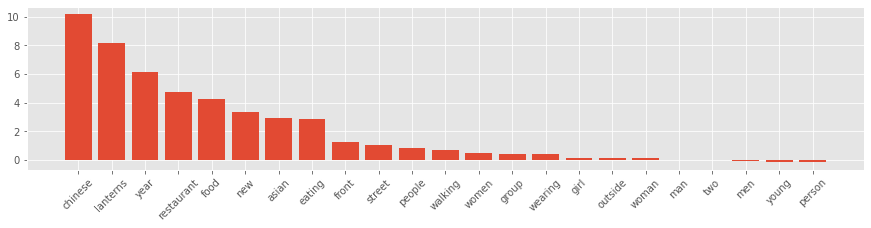

In [439]:
get_n_highest('chinese', pmi_hyp, n=60, plot=True)

### Comparison between young-old/elderly

In [440]:
young_old_prem = compare('young', 'old', source=pmi_premise)
young_old_hyp = compare('young', 'old', source=pmi_hyp)

young_eld_prem = compare('young', 'elderly', source=pmi_premise)
young_eld_hyp = compare('young', 'elderly', source=pmi_hyp)

In [443]:
young_old_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_young,pmi_old,diff
136,old,-0.373822,6.640377,-7.014199
165,buildings,-1.328461,2.438030,-3.766491
150,beard,-0.726350,2.843029,-3.569378
164,newspaper,-1.187302,2.322698,-3.510000
153,selling,-0.842084,2.095026,-2.937110
145,bearded,-0.620104,2.180945,-2.801049
52,style,0.182844,2.967951,-2.785107
154,building,-0.843085,1.847558,-2.690642
138,stone,-0.376341,2.252646,-2.628988
162,shop,-1.159681,1.455501,-2.615182


In [444]:
young_old_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_young,pmi_old,diff
0,young,3.632877,-0.373822,4.006699
3,girl,1.581394,-1.572322,3.153716
2,boy,1.814733,-0.958544,2.773277
1,boys,1.832486,-0.635748,2.468234
65,water,0.035630,-1.708612,1.744241
15,shorts,0.613656,-0.783599,1.397255
8,pink,0.823331,-0.553833,1.377164
19,children,0.491521,-0.872235,1.363756
9,plays,0.799171,-0.562564,1.361734
5,child,1.007674,-0.244099,1.251773


In [445]:
young_old_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_young,pmi_old,diff
208,old,-0.125991,6.551716,-6.677707
168,years,0.017256,5.721641,-5.704384
321,cars,-1.666665,0.808901,-2.475566
310,fruit,-1.133303,1.052756,-2.186059
103,chess,0.247485,2.386015,-2.138531
312,truck,-1.233969,0.887960,-2.121929
260,cross,-0.458570,1.531569,-1.990139
153,purse,0.080666,2.041658,-1.960992
301,resting,-0.958274,0.865215,-1.823489
245,pushing,-0.336631,1.479971,-1.816602


In [446]:
young_old_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_young,pmi_old,diff
0,young,5.076150,-0.125991,5.202141
9,girls,1.172319,-2.427403,3.599723
1,boy,1.972930,-1.102428,3.075358
2,girl,1.829272,-0.951570,2.780841
46,soccer,0.579971,-1.831989,2.411960
4,male,1.478335,-0.805836,2.284171
5,boys,1.393865,-0.751512,2.145376
3,skateboard,1.570692,-0.505538,2.076230
10,school,1.161211,-0.822655,1.983866
68,jumping,0.446365,-1.465093,1.911458


In [640]:
young_eld_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_young,pmi_elderly,diff
0,young,3.632877,-0.985603,4.618480
2,girl,1.581394,-2.499879,4.081273
1,boy,1.814733,-1.985636,3.800369
3,child,1.007674,-1.323659,2.331332
47,water,0.035630,-1.553706,1.589336
18,playing,0.426647,-1.091669,1.518316
24,beach,0.341673,-0.800776,1.142449
16,looks,0.459800,-0.542051,1.001851
6,pink,0.823331,-0.159461,0.982793
8,plays,0.799171,-0.168192,0.967363


In [641]:
young_eld_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_young,pmi_elderly,diff
110,elderly,-0.985603,7.297783,-8.283385
67,gentleman,-0.126115,3.838351,-3.964466
84,younger,-0.249766,2.678174,-2.927940
76,bench,-0.170142,2.482589,-2.652731
114,shop,-1.159681,1.434835,-2.594516
112,tan,-1.139712,1.425657,-2.565370
72,graffiti,-0.144731,2.091332,-2.236062
35,couple,0.269862,2.412541,-2.142679
86,scarf,-0.267365,1.861488,-2.128853
100,stone,-0.376341,1.703602,-2.079943


In [642]:
young_eld_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_young,pmi_elderly,diff
0,young,5.076150,-0.970543,6.046693
1,boy,1.972930,-2.522222,4.495152
11,playing,0.501025,-0.443204,0.944229
22,bike,0.199601,-0.538686,0.738287
6,shirt,0.706707,-0.000719,0.707426
3,plays,0.984417,0.282572,0.701845
43,watching,-0.025545,-0.677323,0.651778
13,red,0.482243,-0.081819,0.564062
35,three,0.029991,-0.512376,0.542367
17,picture,0.376047,-0.028817,0.404863


In [643]:
young_eld_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_young,pmi_elderly,diff
69,elderly,-0.970543,8.578177,-9.548721
72,driving,-1.257005,1.245022,-2.502027
62,coat,-0.390392,2.047505,-2.437897
42,bench,-0.020829,2.368724,-2.389553
64,selling,-0.494654,1.707813,-2.202467
10,couple,0.526060,2.425423,-1.899363
66,shopping,-0.645709,1.145825,-1.791534
67,food,-0.647772,0.873364,-1.521136
31,couch,0.093353,1.544754,-1.451401
9,chair,0.543794,1.952712,-1.408918


# POPULAR STEREOTYPES ANALYSIS

### Sports

In [469]:
get_pmi("woman", "player"), get_pmi("man", "player")

(-2.8702845032144824, -3.144151186229639)

In [486]:
get_pmi("woman", "football"), get_pmi("man", "football")

(-3.073644110930758, -1.6776593956382457)

In [490]:
get_pmi("woman", "basketball"), get_pmi("man", "basketball")

(-2.5850366741047375, -1.0780206464234812)

In [531]:
get_pmi("woman", "sports"), get_pmi("man", "sports")

(-0.6988823719298658, -0.0033373747784456688)

In [532]:
get_pmi("girl", "sports"), get_pmi("boy", "sports")

(-0.5075042608212358, 0.21318900991680423)

In [536]:
get_pmi("girls", "baseball"), get_pmi("boys", "baseball")

(-1.0506720131635132, -0.036777571505132375)

In [537]:
get_pmi("girl", "baseball"), get_pmi("boy", "baseball")

(-0.7759061271572818, 0.9455857569644998)

### Are women really #domesticated ?

In [491]:
get_pmi("woman", "kitchen"), get_pmi("man", "kitchen")

(0.6160098280829995, 0.14332326999748335)

In [624]:
get_pmi("woman", "groceries"), get_pmi("man", "groceries")

(1.3918908998902189, -0.598182817124347)

In [625]:
get_pmi("woman", "laundry"), get_pmi("man", "laundry")

(1.2169249891826481, -0.05694169383250857)

In [611]:
get_pmi("woman", "ironing")

2.1022008620553723

In [590]:
get_pmi("woman", "dishwasher")

2.05419548914454

In [612]:
get_pmi("woman", "apron"), get_pmi("man", "apron")

(1.4386285266378496, 0.9562917985186143)

In [613]:
get_pmi("woman", "sewing"), get_pmi("man", "sewing")

(1.771755684138153, 0.3693742606003158)

In [615]:
get_pmi("woman", "knitting")

1.8032339156113208

### School

In [497]:
get_pmi("woman", "children"), get_pmi("man", "children")

(-0.8554580087592063, -1.709476461551433)

In [508]:
get_pmi("woman", "school"), get_pmi("man", "school")

(-1.5016206659170999, -2.2755609520669)

In [505]:
get_pmi("girls", "school"), get_pmi("boys", "school")

(1.9932594073324466, 2.100263253382309)

In [506]:
get_pmi("girl", "school"), get_pmi("boy", "school")

(0.5642265631076713, 0.35600293190719384)

In [620]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'school' == j], key=lambda x: x[1], reverse=True)

[(('boys', 'school'), 2.100263253382309),
 (('girls', 'school'), 1.9932594073324466),
 (('asian', 'school'), 1.1263524822509696),
 (('girl', 'school'), 0.5642265631076713),
 (('young', 'school'), 0.39256273055077884),
 (('boy', 'school'), 0.35600293190719384),
 (('men', 'school'), -0.8929338607985076),
 (('white', 'school'), -0.9864085198543869),
 (('black', 'school'), -1.1972858244385023),
 (('woman', 'school'), -1.5016206659170999),
 (('man', 'school'), -2.2755609520669)]

In [621]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'graduation' == j], key=lambda x: x[1], reverse=True)

[(('woman', 'graduation'), 1.6343570036018749)]

In [627]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'studies' == j], key=lambda x: x[1], reverse=True)

[(('man', 'studies'), 1.1167564707118602)]

### Clothing

In [509]:
get_pmi("woman", "blouse"), get_pmi("man", "shirt")

(2.414668627693668, 1.022760659622288)

### Occupation

In [525]:
pmi_premise[("man", "construction")], pmi_premise[("woman", "construction")]

(-0.6465495156331262, -3.035302661694563)

In [526]:
pmi_premise[("man", "hospital")], pmi_premise[("woman", "construction")]

(-0.5946740313472082, -3.035302661694563)

In [527]:
pmi_premise[("man", "working")], pmi_premise[("woman", "working")]

(0.2848708781499032, -0.392098024021916)

In [528]:
pmi_premise[("man", "work")], pmi_premise[("woman", "work")]

(0.09670832734880785, -1.2252758064999276)

In [619]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'work' == j], key=lambda x: x[1], reverse=True)

[(('men', 'work'), 1.826354494467393),
 (('male', 'work'), 0.4507296572081672),
 (('asian', 'work'), 0.3502299217740062),
 (('man', 'work'), 0.09670832734880785),
 (('old', 'work'), 0.038977153014753935),
 (('women', 'work'), -0.03190928654750641),
 (('white', 'work'), -0.669421675939869),
 (('young', 'work'), -0.705487924813547),
 (('black', 'work'), -1.0989392669993248),
 (('woman', 'work'), -1.2252758064999276),
 (('boy', 'work'), -1.6425120499062176)]

### Young people/women are attractive

In [540]:
get_pmi("young", "attractive")

1.8552694812209372

In [541]:
get_pmi("woman", "attractive")

2.0606217583039728

In [544]:
get_pmi("woman", "beautiful")

0.22141797020702886

### Asians are smart, dancy, traditional and mostly women?

In [545]:
get_pmi("asian", "school")

1.1263524822509696

In [551]:
get_pmi("asian", "restaurant")

1.1430312233975999

In [560]:
get_pmi("indian", "dancing")

2.6849795394018026

In [561]:
get_pmi("asian", "traditional"), get_pmi("indian", "traditional")

(2.927043674027563, 4.830318902565842)

In [567]:
get_pmi("asian", "woman"), get_pmi("asian", "man")

(0.49656824734579735, -0.09435971640141393)

In [568]:
get_pmi("indian", "woman"), get_pmi("indian", "man")

(0.673219825939329, -0.0011847866595566202)

### women are more likely to be described by their physique especially if they are not white

In [570]:
get_pmi("asian", "woman"), get_pmi("asian", "man")

(0.49656824734579735, -0.09435971640141393)

In [571]:
get_pmi("indian", "woman"), get_pmi("indian", "man")

(0.673219825939329, -0.0011847866595566202)

In [572]:
get_pmi("caucasian", "woman"), get_pmi("caucasian", "man")

(0.12017860298442776, -0.035246622733189646)

In [580]:
get_pmi("woman", "attractive")

2.0606217583039728

In [575]:
# get_pmi("man", "handsome") does not exist

In [576]:
get_pmi("woman", "beautiful")

0.22141797020702886

In [577]:
get_pmi("woman", "blouse"), get_pmi("man", "shirt")

(2.414668627693668, 1.022760659622288)

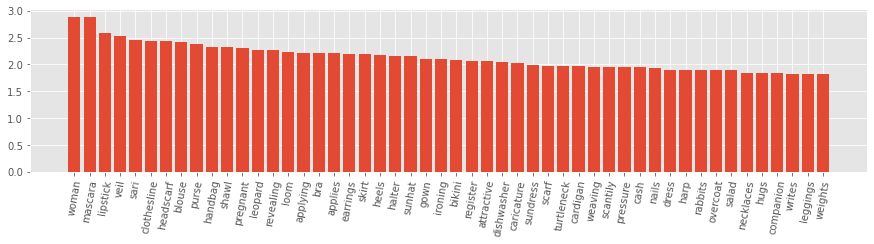

In [588]:
get_n_highest("woman", pmi_premise, n=50, plot=True, rotation=80, figsize=(15, 3))

In [606]:
get_pmi("woman", "short")

1.2897041463215553

In [607]:
get_pmi("man", "short")

0.2977975043483466

In [626]:
get_n_highest("man", pmi_premise, n=200, plot=False, rotation=80, figsize=(15, 3))

[(('man', 'man'), 1.9647533772668104),
 (('man', 'girlfriend'), 1.8867508652655374),
 (('man', 'mustached'), 1.8578381733502984),
 (('man', 'shaves'), 1.8578381733502984),
 (('man', 'breakdances'), 1.8492761598468743),
 (('man', 'necktie'), 1.8272498535168755),
 (('man', 'rearing'), 1.8272498535168755),
 (('man', 'balding'), 1.8162308525567223),
 (('man', 'beard'), 1.8093990743221224),
 (('man', 'bearded'), 1.7935667272605869),
 (('man', 'harmonica'), 1.789666670708719),
 (('man', 'mustache'), 1.7825500460460613),
 (('man', 'duffel'), 1.7423609559303623),
 (('man', 'tuning'), 1.7423609559303623),
 (('man', 'tuxedo'), 1.7208277943807213),
 (('man', 'goatee'), 1.7196408794302789),
 (('man', 'razor'), 1.7017189714330165),
 (('man', 'carves'), 1.7017189714330165),
 (('man', 'beret'), 1.6955667444514213),
 (('man', 'shined'), 1.684645458074075),
 (('man', 'turban'), 1.6752467600718255),
 (('man', 'spider'), 1.6752467600718255),
 (('man', 'undershirt'), 1.6651930954079026),
 (('man', 'shingl

### Man doing manly things

In [628]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'weapon' == j], key=lambda x: x[1], reverse=True)

[(('man', 'weapon'), 1.176257482460522)]

In [629]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'knife' == j], key=lambda x: x[1], reverse=True)

[(('man', 'knife'), 1.1942352233895777)]

In [630]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'aiming' == j], key=lambda x: x[1], reverse=True)

[(('man', 'aiming'), 1.1992186309038333)]

In [631]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'operates' == j], key=lambda x: x[1], reverse=True)

[(('man', 'operates'), 1.2162921442627748)]

In [632]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'hammer' == j], key=lambda x: x[1], reverse=True)

[(('boy', 'hammer'), 1.2325689906589146),
 (('man', 'hammer'), 1.227787783100604),
 (('young', 'hammer'), 0.7545556164727415)]

In [635]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'inspects' == j], key=lambda x: x[1], reverse=True)

[(('man', 'inspects'), 1.2147316302751578)]

In [636]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'welds' == j], key=lambda x: x[1], reverse=True)

[(('man', 'welds'), 1.3367221546537682)]

In [637]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'sculpting' == j], key=lambda x: x[1], reverse=True)

[(('man', 'sculpting'), 1.3546998955828236)]

In [638]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'rifle' == j], key=lambda x: x[1], reverse=True)

[(('man', 'rifle'), 1.410164525589173)]

In [639]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'blowtorch' == j], key=lambda x: x[1], reverse=True)

[(('man', 'blowtorch'), 1.5497158779879665)]

### Men smile less

In [656]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'smiling' == j], key=lambda x: x[1], reverse=True)

[(('girls', 'smiling'), 1.06794887265747),
 (('women', 'smiling'), 0.9742261909911418),
 (('girl', 'smiling'), 0.9264340925342256),
 (('woman', 'smiling'), 0.8212641233295175),
 (('asian', 'smiling'), 0.8062176691866579),
 (('young', 'smiling'), 0.7834439212140201),
 (('boy', 'smiling'), 0.6562359556952372),
 (('african', 'smiling'), 0.6161177405293641),
 (('boys', 'smiling'), 0.4737972004816534),
 (('female', 'smiling'), 0.38181534209589735),
 (('elderly', 'smiling'), 0.2841608724115956),
 (('black', 'smiling'), -0.007559592022376512),
 (('man', 'smiling'), -0.02967482806351559),
 (('old', 'smiling'), -0.09313730782431784),
 (('white', 'smiling'), -0.11861038232562375),
 (('male', 'smiling'), -0.12499145510651902),
 (('men', 'smiling'), -0.4147025350324698)]